# Machine learning on spectral data

- Spectral data obtained from a spectrometer from sampling a liquid (details are witheld due to confidentiality)
- Project aims to predict test results for 'M' 'F' 'P' or 'C' using the spectral properties of the sample
- All results are continuous variables - this is a regression problem
- Since spectral data across 2047 wavelengths between 336-1015 nm, and there are a total of 150 samples (x6 reads), this is a very wide dataset -> data reduction is required
- Since variation of wavelength intensity across the spectrum >> variation between samples at given wavelength, some standardisation is required
- Current data is 1/6 of total sample: this notebook only aims to generate candidate models for future testing

### Feature preprocessing

- Converted values to z-score for each wavelength, essentially flattening the shape of the spectral signature
- Sampled only between 400 nm and 822 nm (1230 points)
- Took a mean across each 10 points (123 points)

### Models attempted

- Artificial neural networks built using Keras Sequential() with Dense() connetions
- Lasso regression
- Support Vector Regression
- Random Forest Regression

### Notes: 24/12/2017

- Model generated for 'P', try other dependent variables next
- Can SVM model be applied to another test dataset? 
- Can performance of neural net be enhanced by a larger training dataset (by combining with the other data)?

In [223]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
% matplotlib inline

In [224]:
directory = "Raw_Datafiles/"
files=[]
filenames= [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
for f in filenames:
    frame = pd.read_table(f, index_col = None, header = None)
    readname = f.split('_')[1].split('/')[1]
    readnumber = f.split('_')[-1].split('.')[0]
    frame['Order']= readname
    frame['Read']= readnumber
    files.append(frame)
df_long = pd.concat(files)
df_long.columns= ['Wavelength', 'Intensity','Order', 'Read']

In [226]:
resultfile = pd.read_csv('Test Results CR08MAR17.csv').drop('Order',1)
resultfile.columns = ['Order', 'ID','M','F','P','C']
IDvar = resultfile[['Order','ID']]
df_long = pd.merge(df_long, IDvar, on = 'Order', how ='inner' )

In [227]:
df_wide = df_long.set_index(['Order','ID','Read','Wavelength']).unstack('Wavelength')

In [228]:
df_wide.head()

Intensity                                               \
Wavelength       336.856  337.233  337.609  337.986  338.363  338.739    
Order ID   Read                                                          
01A   4468 1      -121.32  -121.32  -121.32  -162.00   -98.73   -82.91   
           2      -190.39  -190.39  -190.39  -174.57   -84.18  -106.78   
           3      -132.34  -132.34  -132.34  -127.82   -91.66   -57.77   
           4      -151.13  -151.13  -151.13  -164.68   -96.89  -130.79   
           5      -165.39  -165.39  -165.39  -142.79   -84.04  -163.13   

                                                      ...              \
Wavelength      339.116  339.492  339.869  340.245    ...    1013.429   
Order ID   Read                                       ...               
01A   4468 1      -94.21   -55.79   -85.17   -71.61   ...      289.96   
           2      -90.96  -124.86   -95.48   -72.88   ...      331.63   
           3     -109.74  -141.38     7.77   -69.07   ...      281.21   
           4      -76.55  -128.53   -78.81    18.36   ...      348.30   
           5     -133.75   -99.86   -11.72   -63.70   ...      263.98   

                                                                       \
Wavelength      1013.710 1013.991 1014.271 1014.552 1014.832 1015.112   
Order ID   Read                                                         
01A   4468 1      228.95   339.68   224.43   215.39   285.44   289.96   
           2      250.28   309.03   216.38   211.86   211.86   252.54   
           3      247.31   312.84   260.87   236.01   306.07   254.09   
           4      237.56   364.11   192.37   278.24   282.76   266.94   
           5      259.46   252.68   279.79   209.74   277.54   257.20   

                                            
Wavelength      1015.393 1015.673 1015.953  
Order ID   Read                             
01A   4468 1      219.91   219.91   219.91  
           2      259.32   259.32   259.32  
           3      299.29   299.29   299.29  
           4      280.50   280.50   280.50  
           5      236.86   236.86   236.86  

[5 rows x 2048 columns]

In [229]:
df_long.head()

,Wavelength,Intensity,Order,Read,ID
0,336.856,-121.32,01A,1,4468
1,337.233,-121.32,01A,1,4468
2,337.609,-121.32,01A,1,4468
3,337.986,-162.00,01A,1,4468
4,338.363,-98.73,01A,1,4468


In [230]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843200 entries, 0 to 1843199
Data columns (total 5 columns):
Wavelength    float64
Intensity     float64
Order         object
Read          object
ID            int64
dtypes: float64(2), int64(1), object(2)
memory usage: 84.4+ MB


In [231]:
df_long.describe()

,Wavelength,Intensity,ID
count,1.843200e+06,1.843200e+06,1.843200e+06
mean,6.928814e+02,6.112872e+03,4.116967e+03
std,1.966618e+02,1.102912e+04,4.355466e+02
min,3.368560e+02,-2.795100e+02,2.551000e+03
25%,5.245440e+02,2.689200e+02,4.133000e+03
50%,7.011320e+02,4.282400e+02,4.259500e+03
75%,8.653560e+02,5.734740e+03,4.384000e+03
max,1.015953e+03,6.221009e+04,4.481000e+03


In [232]:
import numpy as np
df_grouped = df_long.groupby(['ID', 'Wavelength'])
avged = df_grouped.agg([np.mean, np.std])
avged.columns = avged.columns.droplevel(0)
avged_total = avged.reset_index().drop(['std','ID'],1).groupby('Wavelength').agg([np.mean,np.std])

In [233]:
avged_total.columns = avged_total.columns.droplevel(0)
avged_total = avged_total.reset_index()

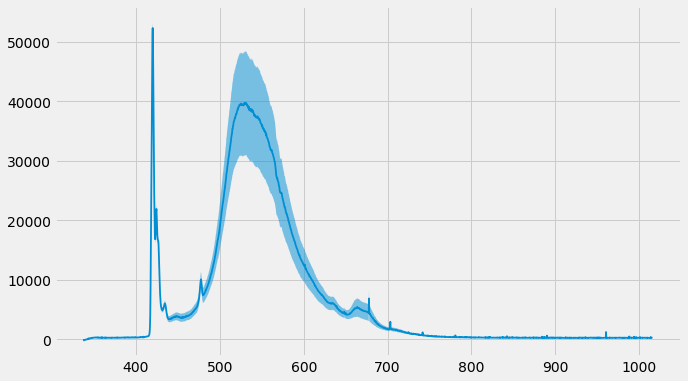

In [234]:
x = avged_total['Wavelength']
y = avged_total['mean']
yerror = avged_total['std']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (10,6))

ax.plot(x,y, linewidth = 1.8)
ax.fill_between(x,y-yerror, y+yerror, alpha = 0.5)

In [235]:
# get background data - may help with noise reduction (blips)
directory = "Background/"
files=[]
filenames= [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.txt')]
for f in filenames:
    frame = pd.read_table(f, index_col = None, header = None)
    readnumber = f.split('_')[-1].split('.')[0]
    frame['Read']= readnumber
    files.append(frame)
background = pd.concat(files)
background.columns= ['Wavelength', 'Intensity','Read']

In [236]:
background_summ = background.groupby('Wavelength').agg([np.mean, np.std])

In [237]:
background_summ.columns=background_summ.columns.droplevel(0)
background_summ= background_summ.reset_index()

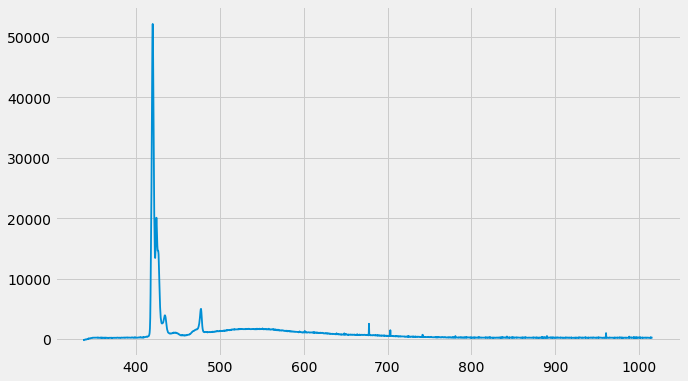

In [238]:
x = background_summ['Wavelength']
y = background_summ['mean']
yerror = background_summ['std']

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(x,y, linewidth = 1.8)
ax.fill_between(x, y-yerror, y+yerror, alpha =0.5)

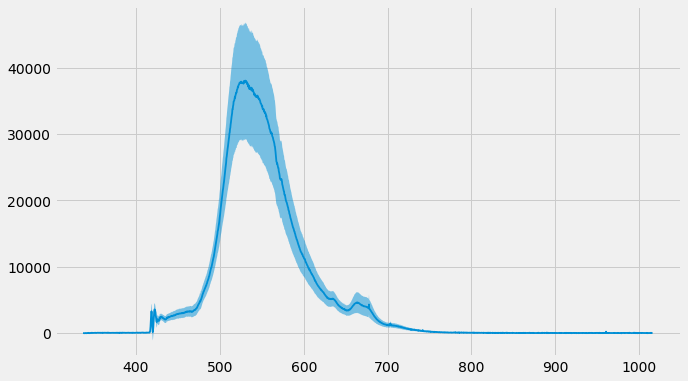

In [239]:
#subtract baseline
x = avged_total['Wavelength']
y = avged_total['mean']- background_summ['mean']
yerror = avged_total['std']+background_summ['std']

subtracted = pd.DataFrame([x,y,yerror]).transpose()

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(x,y, linewidth = 1.8)
ax.fill_between(x, y-yerror, y+yerror, alpha =0.5)

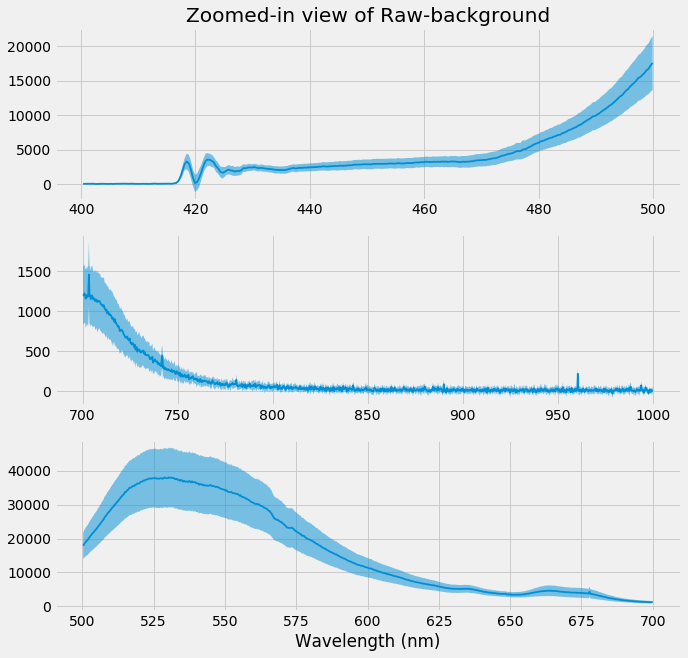

In [240]:
#zoom into 400-450 nm
zoomed = subtracted.loc[subtracted['Wavelength'].between(400,500)]
zoomed2 = subtracted.loc[subtracted['Wavelength'].between(700,1000)]
zoomed3 = subtracted.loc[subtracted['Wavelength'].between(500,700)]
x = zoomed['Wavelength']
y = zoomed['mean']
yerror = zoomed['std']
x2 = zoomed2['Wavelength']
y2 = zoomed2['mean']
yerror2 = zoomed2['std']
x3= zoomed3['Wavelength']
y3= zoomed3['mean']
yerror3= zoomed3['std']
fig, ax = plt.subplots(3,1, figsize = (10,10))
ax[0].plot(x,y, linewidth = 1.8)
ax[0].fill_between(x, y-yerror, y+yerror, alpha =0.5)
ax[1].plot(x2,y2, linewidth = 1.8)
ax[1].fill_between(x2, y2-yerror2, y2+yerror2, alpha =0.5)
ax[2].set_xlabel('Wavelength (nm)')
ax[0].set_title('Zoomed-in view of Raw-background')
ax[2].plot(x3,y3,linewidth = 1.8)
ax[2].fill_between(x3,y3-yerror3, y3+yerror3, alpha = 0.5)

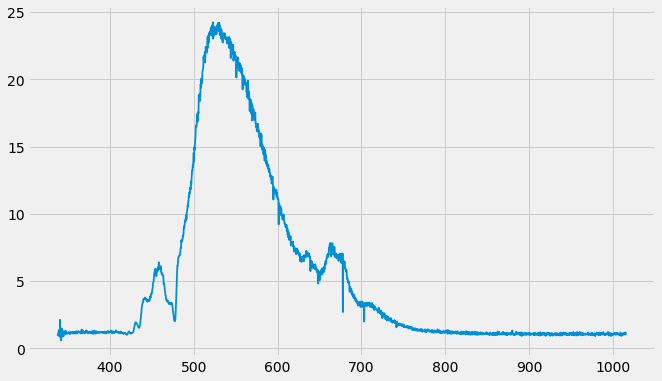

In [241]:
# standardised by baseline (measure / baseline)
## causes a lot of jitter here 
x = avged_total['Wavelength']
y = avged_total['mean']/ background_summ['mean']

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(x,y, linewidth = 1.8)

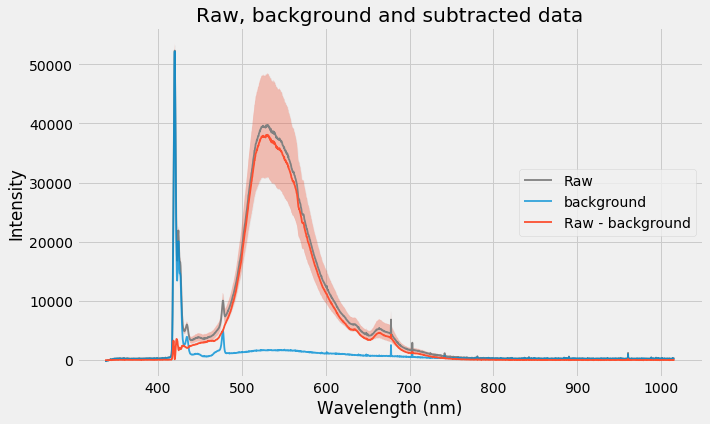

In [242]:
# plot together
x = avged_total['Wavelength']
y = avged_total['mean']
yerror = avged_total['std']

x2 = background_summ['Wavelength']
y2 = background_summ['mean']
yerror2 = background_summ['std']

x3 = avged_total['Wavelength']
y3 = avged_total['mean']- background_summ['mean']
yerror3 = avged_total['std']+background_summ['std'] #error increases when compounded

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(x,y, linewidth = 1.8, label = 'Raw', color= 'gray')
ax.fill_between(x, y-yerror, y+yerror, alpha =0.05, color = 'gray')
ax.plot(x2,y2, linewidth = 1.8, alpha = 0.8, label = 'background')
ax.fill_between(x2,y-yerror2, y+yerror2, alpha = 0.1)
ax.plot(x3,y3, linewidth = 1.8, label = 'Raw - background')
ax.fill_between(x3, y-yerror3, y+yerror3, alpha =0.3)
ax.legend(loc = 'right')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Intensity')
ax.set_title('Raw, background and subtracted data')

In [243]:
# Standardization data at each wavelength? 
 ##from sklearn.preprocessing import scale
zscore = lambda x: (x - x.mean()/ x.std())
subtracted_norm = subtracted.iloc[:,:2].groupby('Wavelength').transform(zscore)

In [244]:
background_sub= background_summ.iloc[:, :3].unstack()

In [245]:
df_wide.columns = df_wide.columns.droplevel(0)
df_wide= df_wide.reset_index()
df_wide.head()

Wavelength,Order,ID,Read,336.856,337.233,337.60900000000004,337.986,338.36300000000006,338.73900000000003,339.116,...,1013.429,1013.71,1013.9910000000001,1014.2710000000001,1014.552,1014.832,1015.112,1015.393,1015.673,1015.953
0,01A,4468,1,-121.32,-121.32,-121.32,-162.00,-98.73,-82.91,-94.21,...,289.96,228.95,339.68,224.43,215.39,285.44,289.96,219.91,219.91,219.91
1,01A,4468,2,-190.39,-190.39,-190.39,-174.57,-84.18,-106.78,-90.96,...,331.63,250.28,309.03,216.38,211.86,211.86,252.54,259.32,259.32,259.32
2,01A,4468,3,-132.34,-132.34,-132.34,-127.82,-91.66,-57.77,-109.74,...,281.21,247.31,312.84,260.87,236.01,306.07,254.09,299.29,299.29,299.29
3,01A,4468,4,-151.13,-151.13,-151.13,-164.68,-96.89,-130.79,-76.55,...,348.30,237.56,364.11,192.37,278.24,282.76,266.94,280.50,280.50,280.50
4,01A,4468,5,-165.39,-165.39,-165.39,-142.79,-84.04,-163.13,-133.75,...,263.98,259.46,252.68,279.79,209.74,277.54,257.20,236.86,236.86,236.86


In [246]:
background_transposed = background_summ.set_index('Wavelength').T
int_df= pd.concat([background_transposed, df_wide.iloc[:, 3:]]).drop('std')
subtracted = pd.DataFrame(int_df- int_df.iloc[0,:].values.squeeze()).drop('mean').join(df_wide.iloc[:,:3])

In [247]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
norm =pd.DataFrame(scaler.fit_transform(subtracted.iloc[:,:-3]), columns = subtracted.iloc[:,:-3].columns).join(subtracted.iloc[:,-3:])

normalized_df = norm.groupby('ID').agg(np.mean).reset_index()
subtracted_df = subtracted.groupby('ID').agg(np.mean).reset_index()

## Artificial Neural Net for prediction of outcome variables

In [252]:
# split into range of 10
subtracted_df = pd.merge(subtracted_df,resultfile, on = 'ID')

df_ID = subtracted_df.iloc[:,0]
df_trunc = subtracted_df.iloc[:,305:1400] # wavelength between 450 and 800 still too wide, average over 10 wavelengths instead
df_dep = subtracted_df.iloc[:, -4:]

In [256]:
# split into range of 10
normalized_df = pd.merge(normalized_df,resultfile, on = 'ID')

df_ID = normalized_df.iloc[:,0]
df_trunc = normalized_df.iloc[:,170:1400] # wavelength between 400 and 822 still too wide, average over 10 wavelengths instead
df_dep = normalized_df.iloc[:, -4:]

In [257]:
df_dep.head()

,M,F,P,C
0,17.7,4.36,3.58,36
1,13.4,4.35,3.59,89
2,22.9,4.37,3.71,21
3,9.9,4.53,3.31,17
4,20.4,4.29,3.66,136


In [258]:
def avg_over_col(df, num_col):
    new_df = pd.DataFrame()
    curr_col = 0
    for i in range(num_col,len(df.columns)+1, num_col):
        working_df = df.iloc[:,curr_col:i]
        colname = str(working_df.columns[0])
        new_df[colname]=working_df.mean(axis = 1)
        curr_col += num_col
    return(new_df)

In [259]:
X = avg_over_col(df_trunc,10)

In [260]:
print('nrow',len(X), 'ncol',len(X.columns))
# some room to play now

nrow 150 ncol 123


In [261]:
Y= df_dep['P']

In [262]:
from keras.models import Sequential
from keras.layers import Dense
import keras.regularizers as kr
from scipy.stats import linregress
from sklearn.metrics import r2_score

In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state= 42)

mean squared error: 0.33267043232917787 Mean Absolute Error: 0.527143300904168 R-squared: -1.5664712626643214


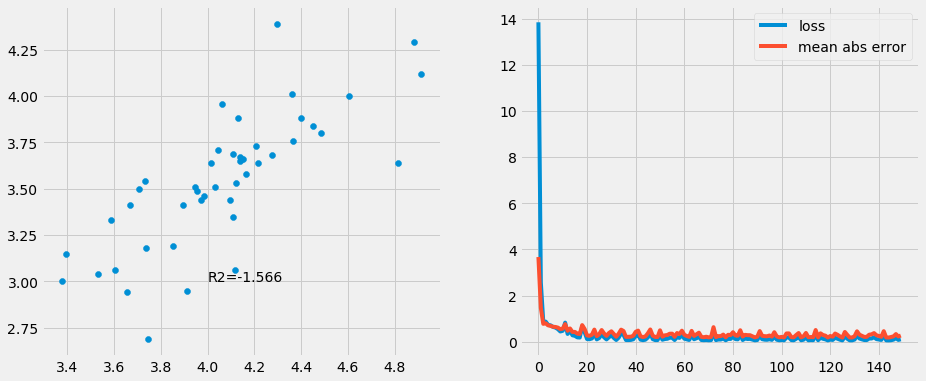

In [264]:
from sklearn.metrics import r2_score
model = Sequential()
model.add(Dense(123, input_dim=123, activation='relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=150, batch_size=50, verbose =0))
# predict
y_predict = model.predict(X_test)
# evaluate
mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
r2 = r2_score(y_test,y_predict.flatten().tolist())
print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()


mean squared error: 0.36119634045494925 Mean Absolute Error: 0.2438694973786672 R-squared: 0.32865277073845023


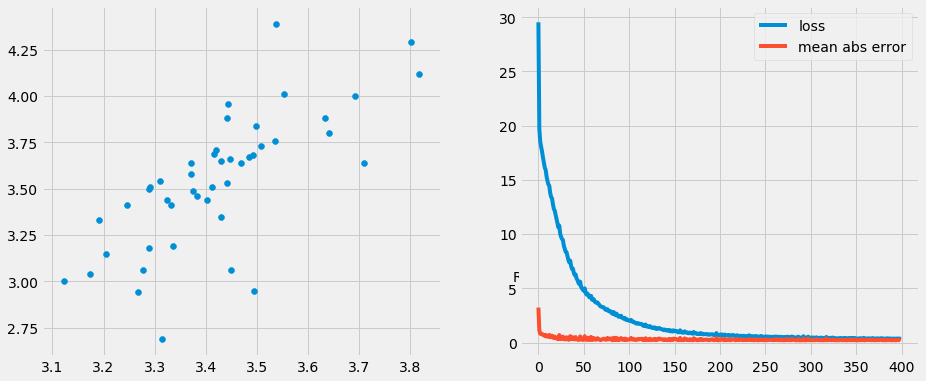

In [265]:
w_reg = kr.l1(0.01)

model = Sequential()
model.add(Dense(123, input_dim=123, activation='relu',kernel_regularizer= w_reg))
model.add(Dense(64, activation = 'relu',kernel_regularizer = w_reg))
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=400, batch_size=50, verbose =0))
# predict
y_predict = model.predict(X_test)
# evaluate
mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
r2 = r2_score(y_test,y_predict.flatten().tolist())
print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.14046677152315776 Mean Absolute Error: 0.2917202724350823 R-squared: -0.08366693709519057


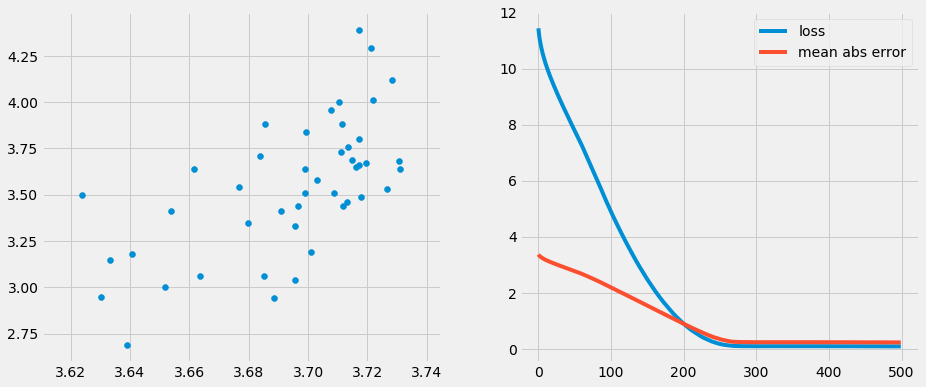

In [268]:
# sigmoid function application to spectral data Viejo et al. 2017
# they only used small chunks of wavelengths to predict.. may need to do more reduction/ regularisation
model = Sequential()
model.add(Dense(5, input_dim=123, activation='sigmoid'))
model.add(Dense(3, activation = 'sigmoid')) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
# predict
y_predict = model.predict(X_test)
# evaluate
mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
r2 = r2_score(y_test,y_predict.flatten().tolist())
print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(3,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.18788898918363783 Mean Absolute Error: 0.29600898292329575 R-squared: -0.15098548520892296


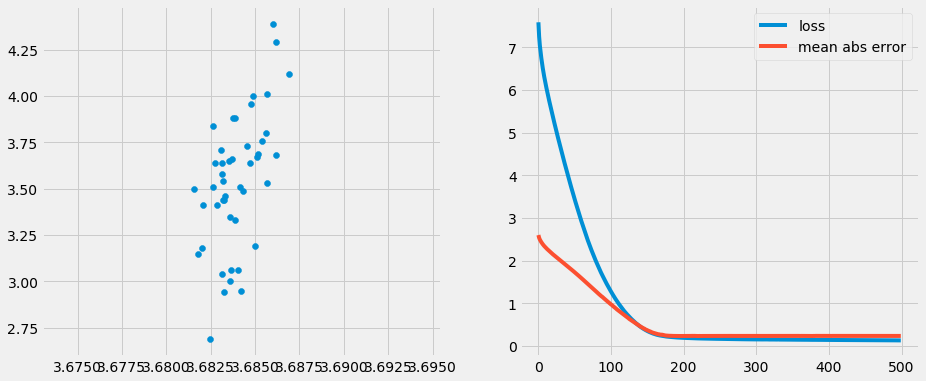

In [269]:
#adding L1 regularisation (LASSO)

w_reg = kr.l1(0.01)

model = Sequential()
model.add(Dense(5, input_dim=123, activation='sigmoid', kernel_regularizer = w_reg))
model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
# predict
y_predict = model.predict(X_test)
# evaluate
mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
r2 = r2_score(y_test,y_predict.flatten().tolist())
print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(4,3,'R2={0}'.format(round(r2,3)))

ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

mean squared error: 0.2187515613105562 Mean Absolute Error: 0.3180979718764623 R-squared: -0.1707101108049931


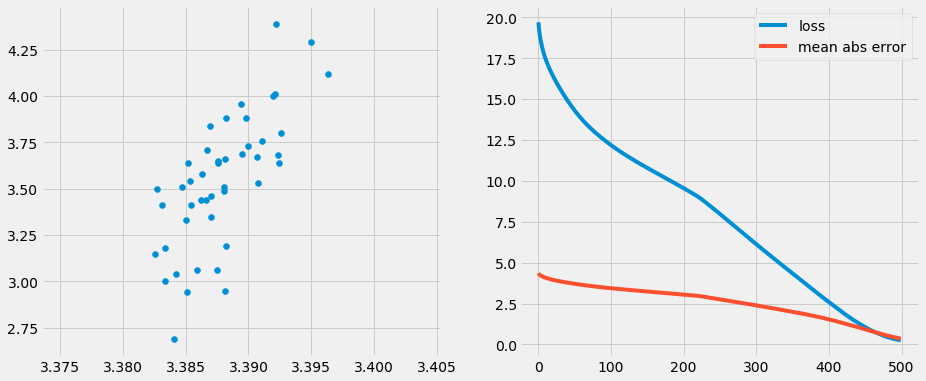

In [270]:
import keras.optimizers as op

w_reg = kr.l1(0.01)
rmsprop = op.RMSprop(lr=0.005)
model = Sequential()
model.add(Dense(5, input_dim=123, activation='sigmoid', kernel_regularizer = w_reg))
model.add(Dense(3, activation = 'sigmoid', kernel_regularizer = w_reg)) # 3 hidden units
model.add(Dense(1))

# compile and fit
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history= (model.fit(X_train, y_train, epochs=500, batch_size=50, verbose =0))
# predict
y_predict = model.predict(X_test)
# evaluate
mse_value, mae_value = model.evaluate(X_test, y_test, verbose = 0)
r2 = r2_score(y_test,y_predict.flatten().tolist())
print("mean squared error:", mse_value, "Mean Absolute Error:", mae_value, "R-squared:",r2 )

fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].scatter(y_predict, y_test)
#ax[0].text(4,3,'R2={0}'.format(round(r2,3)))
ax[1].plot(history.history['loss'], label = 'loss')
ax[1].plot(history.history['mean_absolute_error'], label = 'mean abs error')
ax[1].legend()

## Linear regression + lasso regularization 

In [271]:
# linear model, support vector regression?
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [272]:
alphas = [0.001 + (float(i)/1000) for i in range(0, 10)]
for a in alphas:
    est = (Lasso(alpha = a))
    est.fit(X_train, y_train)
    print('alpha:', a, "\n",est.coef_, "\n",est.intercept_)

alpha: 0.001 
 [-0.         -0.         -0.0815199   0.          0.          1.49966475
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.08543371  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.12917706  0.          0.          0.19715091
  0.          0.          0.          0.          0.         -0.
 -0.60542231 -0.          0.          0.          0.          0.
  0.          0.05675924  0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.       

In [273]:
est = (Lasso(alpha = 0.00023418902250102515))
est.fit(X_train, y_train)
print('alpha:', a, "\n",est.coef_, "\n",est.intercept_)

alpha: 0.009999999999999998 
 [-0.16432585 -0.         -1.57791383 -0.          0.15196031  1.84871458
  0.09443893 -0.64552199 -0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.44750629  0.          0.          0.
 -0.         -0.         -0.         -0.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.40515944
  0.1132651   0.          0.          0.          0.         -0.
 -0.43575433 -0.         -0.         -0.          0.          0.
  0.36751137  0.          0.          0.          0.          0.
  0.         -0.         -0.         -0.         -0.         -0.
 -1.54608707 -0.         -0.         -0.2246

c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


c:\users\jj\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


chosen alpha 0.0005167010718119042
r2: 0.5149771001016015


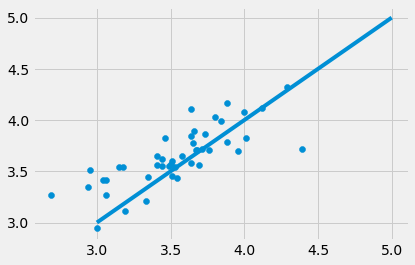

In [274]:
from sklearn.linear_model import LassoCV

model= LassoCV(cv=20)
model.fit(X_train, y_train)
print("chosen alpha", model.alpha_)
y_predict = model.predict(X_test)

fig , ax = plt.subplots()
ax.scatter(y_test,y_predict)
ax.plot([3,5],[3,5])
print('r2:', r2_score(y_test,y_predict))


## Support vector regression

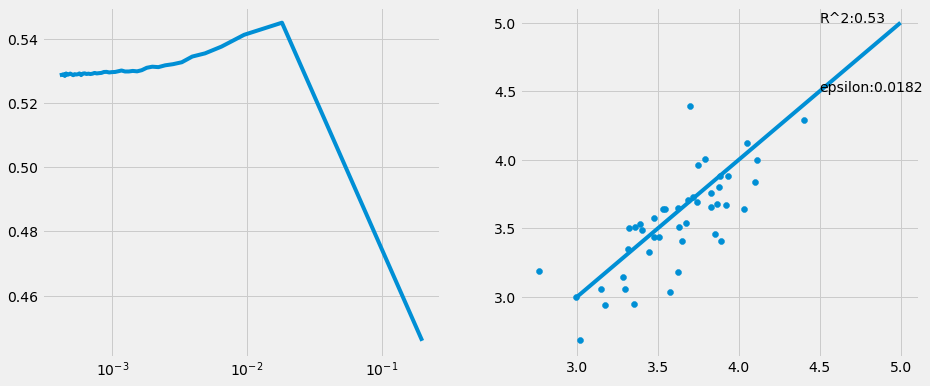

In [275]:
from sklearn.svm import SVR
# Vary epsilon, from initial tests, C appears to not have much effect on prediction accuracy
svr_prediction = []
svr_r2 = []
ep =[]

for i in range(1,500, 10):
    ep.append(0.2/i)
    clf = SVR(C= 100, epsilon = 0.2/i, kernel = 'linear')
    clf.fit(X_train, y_train)
    svr_prediction.append(clf.predict(X_test))
    svr_r2.append(clf.score(X_test,y_test))

fig , ax = plt.subplots(1,2, figsize = (14,6))
ax[1].scatter(svr_prediction[svr_r2.index(max(svr_r2))], y_test)
ax[1].text(4.5,5, "R^2:{0}".format(round(svr_r2[-1],2)))
ax[1].text(4.5,4.5, "epsilon:{0}".format(round(ep[svr_r2.index(max(svr_r2))],4)))
ax[0].plot(ep, svr_r2)
ax[0].set_xscale('log')
ax[1].plot([3,5],[3,5])

## Random Forest

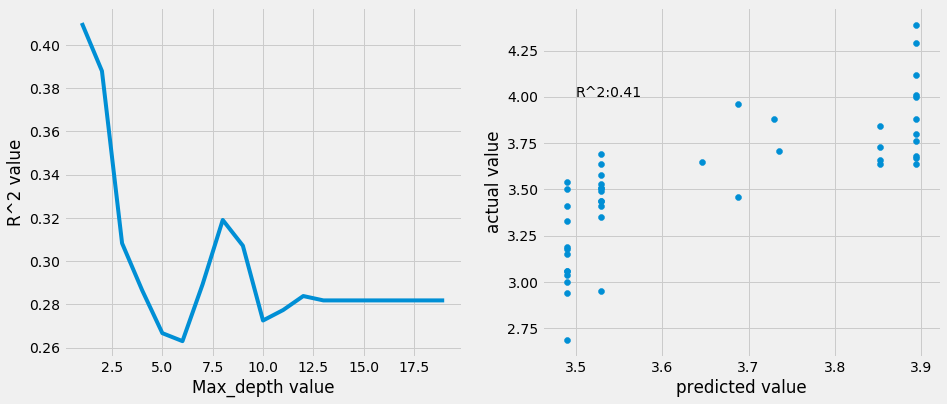

In [280]:
from sklearn.ensemble import RandomForestRegressor
rf_scores = []
predictions=[]
# need to try different max_depth:
for depth in range(1, 20):
    rf = RandomForestRegressor(max_depth = depth, random_state=0)
    rf.fit(X_train, y_train)
    predictions.append(np.array(rf.predict(X_test)))
    rf_scores.append(rf.score(X_test, np.array(y_test)))
    
fig, ax = plt.subplots(1,2, figsize = (14,6))
ax[0].plot(range(1,20),rf_scores)
ax[0].set_ylabel('R^2 value')
ax[0].set_xlabel('Max_depth value')
ax[1].scatter(predictions[rf_scores.index(max(rf_scores))], y_test)
ax[1].text(3.5,4, "R^2:{0}".format(round(max(rf_scores),3)))
ax[1].set_xlabel('predicted value')
ax[1].set_ylabel('actual value')